# Script to solve RSW adjustment problem for $\eta$ from a given initial condition.
### twnh Sep, Oct, Nov '21, Mar '22

We seek the solution to the (non-dimensional) 1-layer RSW adjustment problem.
The problem is to:
1. Determine the $\{ \omega, \eta \}$ pairs from the nonlinear (cubic) eigenproblem.
The problem is (in weak form)
\begin{align}
\int_\Omega  \omega^3 \psi \eta   - \omega \left( \nabla \psi \cdot   \nabla \eta  +  F \psi \eta \right) \; d \Omega - i \sqrt{F} \int_ {\Gamma}  \psi \nabla \eta \cdot {\mathbf t} \; d \Gamma & = 0 ,
\end{align}
where $\eta$ is the solution we require and $\psi$ is a test function. 
* The problem is in a 2D (simply-connected) domain $\Omega$ with boundary $\Gamma$ where ${\mathbf t}$ is the tangent to the boundary running anti-clockwise (to the left of outward unit normal direction ${\bf n}$).
The domain has characteristic (longest) length $L$, which is taken in the horizontal direction (without loss of generality).
The non-dimensional domain therefore has horizontal length 1.
* $F = f^2 L^2 /(g H)$ is the inverse Froude number. The non-rotating limit is $F=0$.
* Time is non-dimensionalized so that the gravity wave crosses the horizontal domain in 1 time unit.
* The deformation radius is therefore given by $1/\sqrt{F}$ in non-dimensional length.

Solving this problem gives $\{ \omega_n, \eta_n \}$ eigenvalue, eigenvector pairs which are the elevation modes oscillating at frequency $\omega_n$.

2. Determine the $\eta_\infty$ steady state solution from the initial PV.
The problem is (in weak form)
\begin{align}
\int_\Omega \nabla \psi \cdot   \nabla \eta_\infty  +  F \psi \eta_\infty  \; d \Omega  & = - \int_\Omega  F \psi \eta_i \; d \Omega .
\end{align}
The inital PV is $Q_i = - \eta_i$, which ASSUMES that the initial flow vanishes (see `theory notes.tex` for the more general case).

3. Determine the $\eta_f$ inertial solution.
The problem is (in weak form)
\begin{align}
\int_\Omega \nabla \psi \cdot   \nabla \eta_f  \; d \Omega + i  \int_ {\Gamma}  \psi \nabla \eta_f \cdot {\mathbf t} \; d \Gamma & = 0 ,
\end{align}
with frequency $\omega = \sqrt{F}$.

4. Determine the expansion coefficients from the initial $\eta$ field ($\eta_i$) and the steady solution $\eta_\infty$.
The problem is to find the coefficients $\alpha_n$ such that
\begin{align}
\eta_i - \eta_\infty & = \Re \Big[ \sum_n \alpha_n \eta_n \Big] , \\
0 & = \Re \Big[ \sum_n - i \omega_n \, \alpha_n \eta_n \Big] , \\
\nabla^2 \eta_i & = \Re \Big[ \sum_n - \omega_n^2 \, \alpha_n \eta_n \Big] , \\
\end{align}
where $\eta_i$ is the initial elevation field, and ASSUMING that the initial vorticity and divergence of the flow vanish (see `theory notes.tex` for the more general case).

5. Animate the solution.
The solution at time $t$ is
\begin{align}
\eta (t) = \eta_\infty + \Re \Big[ \sum_n \alpha_n \eta_n \exp \left( - i \omega_n t\right)  \Big]
\end{align}

#### -1. Housekeeping

In [1]:
using Gridap, GridapGmsh             # FEM package
using LinearAlgebra
using Arpack
using NonlinearEigenproblems         # To solve the cubic eigenproblem

using Interpolations, FileIO         # To read and interpolate results from Oceananigans runs
using BenchmarkTools                 # For performance testing 

using Printf                         # For interface
using GridapMakie
using GLMakie
GLMakie.inline!(true)                # Makes sure figures appear in notebook inline.
using Glob                           # For housekeeping   
using LaTeXStrings

include("RSW_ModelFunctions.jl")     # Function definitions
rm.(glob("output/eta_*"))            # Clean output directory
writeparaView = false ;              # Write paraView files or not
checkEigenFlag = true ;              # Check if eigensolution satisfies original nonlinear eigen problem
trimThreshold = 1.0e-6 ;             # Threshold to trim small eigenvalues. Check figures to make sure this is OK.

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

#### 0. Define problem

In [2]:
#domainName = "square_384nodes_uneven.msh"
# domainName = "square_803nodes_uneven.msh"
domainName = "square_1328nodes_uneven.msh"
# domainName = "square_2903nodes_uneven.msh"        # Slow: computing modes takes 2.5 hours
# domainName = "square_258nodes.msh"
# domainName = "square_145nodes.msh"
# domainName = "circle_268nodes.msh"
#domainName = "rectangle_261nodes.msh"

# The non-dimensionalization sets the longest lengthscale of the non-dimensional domain equal to one.
 U,V,U∞,V∞,Ω,dΩ,dΓ,t_Γ = DefineProblem(domainName)

# Physical parameters: Avoid integer multiples of these parameters (they can throw off the polynomial eigensolver)
#F = 0.0
#F = 0.001
#F = 1.001
#F = 15.98
F = 63.9
#F = 4096.0
f = 1.0e-4      # s^{-1}
g = 9.81        # ms^{-2}
L = 512.0e3     # m 
Lᵣ = sqrt.(L^2 ./ F)
H = ((f * Lᵣ) .^ 2) ./ g
timescale = L ./ sqrt.(g .* H)
@printf("Coriolis parameter                 = [%8.2e] s^{-1}\n",f)
@printf("Gravitational acceleration         = [%8.2f] ms^{-2}\n",g)
@printf("Layer thickness                    = [%8.1f] m\n",H)
@printf("Domain lengthscale                 = [%8.2f] km\n",L/1e3)
@printf("Deformation radius                 = [%8.2f] km\n",Lᵣ/1e3)
@printf("Characteristic timescale           = [%8.2f] days.\n",L/sqrt(g*H)/86400)
@printf("\nInverse Froude number            F = [%8.2f]\n",F)
@printf("Non-dimensional deformation rad.   = [%8.2f]\n\n",1/sqrt(F))

# Initial condition for \eta (non-dimensional)
function ηᵢ(x)
    Deltax = 1/8     # Width of the initial step in \eta
    ηᵢ = tanh(x[1]/Deltax)  # tanh step
    return ηᵢ
end ;

Reading Gmsh discrete model mesh [square_1328nodes_uneven.msh]
Info    : Reading 'square_1328nodes_uneven.msh'...
Info    : 13 entities
Info    : 1328 nodes
Info    : 2654 elements
Info    : Done reading 'square_1328nodes_uneven.msh'
Coriolis parameter                 = [1.00e-04] s^{-1}


Gravitational acceleration         = [    9.81] ms^{-2}
Layer thickness                    = [     4.2] m
Domain lengthscale                 = [  512.00] km
Deformation radius                 = [   64.05] km
Characteristic timescale           = [    0.93] days.

Inverse Froude number            F = [   63.90]
Non-dimensional deformation rad.   = [    0.13]



#### 1. Build polynomial eigenvalue problem and then solve it for the $\omega, \eta$ eigenpairs.

Recall, the eigenproblem is:
\begin{align}
\int_\Omega  \omega^3 \psi \eta   - \omega \left( \nabla \psi \cdot   \nabla \eta  +  F \psi \eta \right) \; d \Omega - i \sqrt{F} \int_ {\Gamma}  \psi \nabla \eta \cdot {\mathbf t} \; d \Gamma & = 0 .
\end{align}

It's hard to assign a particular wavenumber to each spatial mode and thereby compare to the ideal dispersion relations for IGWs and Kelvin waves. Instead, the figure below shows frequency against mode norm.

In [3]:
# Find modes from cubic eigenproblem
ωraw, ηmatraw, ηraw, ηnormraw = solveModesProblem(F) ;


Solving modal problem for (ω,η) eigenpairs with F = [ 63.9000]:
Done in [247.55]s.



Matrix problem size                = [  1328 x   1328]
Number of eigenvalues              = [  3984]


Eigenvalue range                   = [3.12e-20 -- 3.04e+02]
Size of eigenvector matrix         = [  3984 x      1]


Maximum residual for eigenvalue nn = [  3932], ω = [275.595 +  0.000im], max residual = [2.134e-08]



Trimmed [2549] eigenvalues to leave [1435 = 2 x 718] significant eigenvalues with [1328] cells.
Trimmed eigenvalue range           = [1.03e-01 -- 3.04e+02]


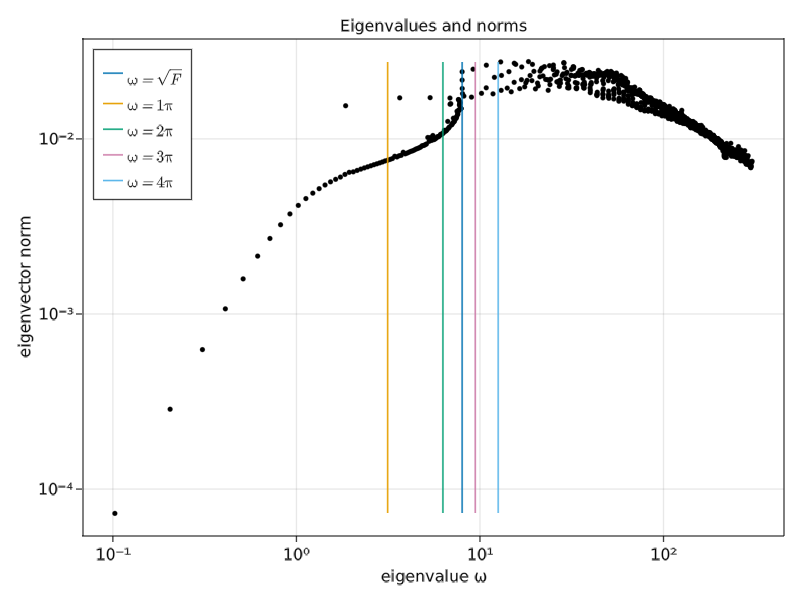

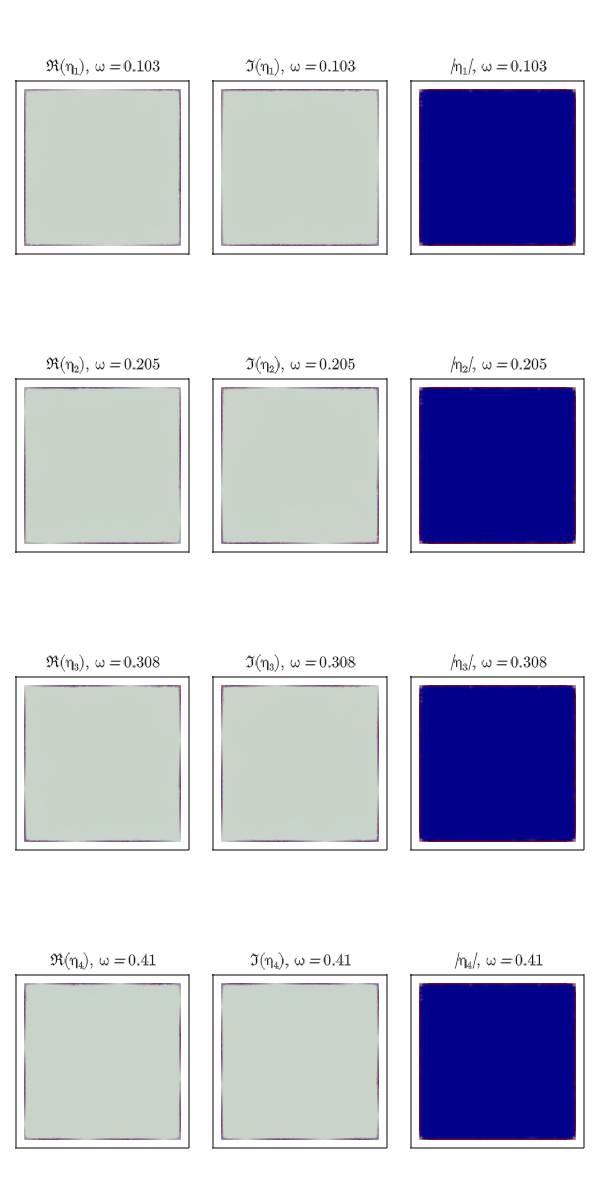

┌ Info: Makie/Makie is caching fonts, this may take a while. Needed only on first run!
└ @ Makie /Users/thaine1/.julia/packages/Makie/NL7Xw/src/utilities/texture_atlas.jl:113


In [4]:
# Trim insignificant eigenvalues and plot
# All modes with frequency > 0
ω, ηmat, η, ηnorm = trimEigen(ωraw,ηmatraw,ηraw,ηnormraw,x -> real(x) > trimThreshold)
plotModes(ω, η, ηnorm,"eta_modes")

#### 2. Find steady solution $\eta_\infty$

Recall, the problem is:
\begin{align}
\int_\Omega \nabla \psi \cdot   \nabla \eta_\infty  +  F \psi \eta_\infty  \; d \Omega  & = - \int_\Omega  F \psi \eta_i \; d \Omega .
\end{align}
The inital PV is $Q_i = - \eta_i$, which ASSUMES that the initial flow vanishes (see `theory notes.tex` for the more general case).



Solving steady problem for η∞.
Done in [  4.68]s.



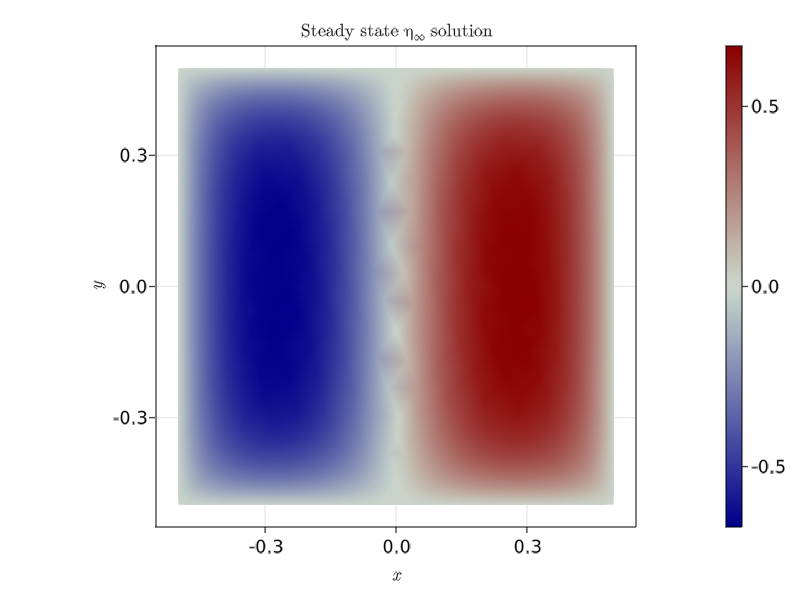

In [5]:
η∞ = solveSteadyProblem()
plotSteadySoln("eta_steady")

#### 2. Find inertial solution $\eta_f$
Recall, the problem is
\begin{align}
\int_\Omega \nabla \psi \cdot   \nabla \eta_f  \; d \Omega + i  \int_ {\Gamma}  \psi \nabla \eta_f \cdot {\mathbf t} \; d \Gamma & = 0 ,
\end{align}
with frequency $\omega = \sqrt{F}$.


Solving inertial problem for η (this mode has frequency ω = √F, but a mode structure independent of F).
Done in [  2.77]s.



Singular value (should be zero): [6.6640e-18 + 4.3960e-33 im].
Singular value (should be zero): [2.3830e-16 + 5.2529e-31 im].


Singular value (should be zero): [1.5587e-09 + 8.4031e-19 im].
Singular value (should be zero): [1.1757e-08 + 1.9415e-16 im].


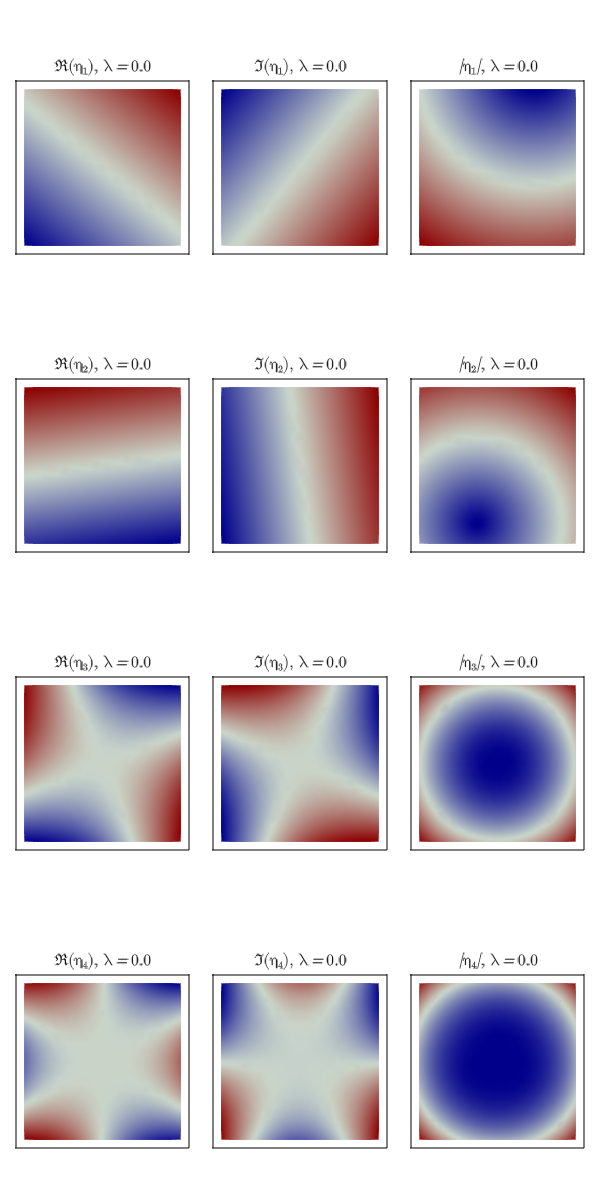

In [6]:
λ, ϕmat, ϕ, ϕnorm = solveInertialProblem()
plotInertialSoln("inertial")

#### 3. Find coefficients of eigenmodes to match the initial condition and steady state
Recall, the problem is to find the coefficients $\alpha_n$ such that
\begin{align}
\eta_i - \eta_\infty & = \Re \Big[ \sum_n \alpha_n \eta_n \Big] , \\
0 & = \Re \Big[ \sum_n - i \omega_n \, \alpha_n \eta_n \Big] , \\
\nabla^2 \eta_i & = \Re \Big[ \sum_n - \omega_n^2 \, \alpha_n \eta_n \Big] , \\
\end{align}
where $\eta_i$ is the initial elevation field, and ASSUMING that the initial vorticity and divergence of the flow vanish (see `theory notes.tex` for the more general case).

Finding expansion coefficients with [1435] modes on a mesh with [1328] nodes:
This ASSUMES the initial divergence and vorticity vanish.


Computing eigenvector expansion of initial condition using SVD. Solves y = Re[ E*x ]:
size(E) = [3984 x 1435], size(y) = [3984] => size(x) = [1435]


get_particular_svd_soln: Using [2870] vectors to construct solution with [0] nullspace vectors.
Residual of (y - real(E*x))'*(y - real(E*x)) = [2.449e-03].


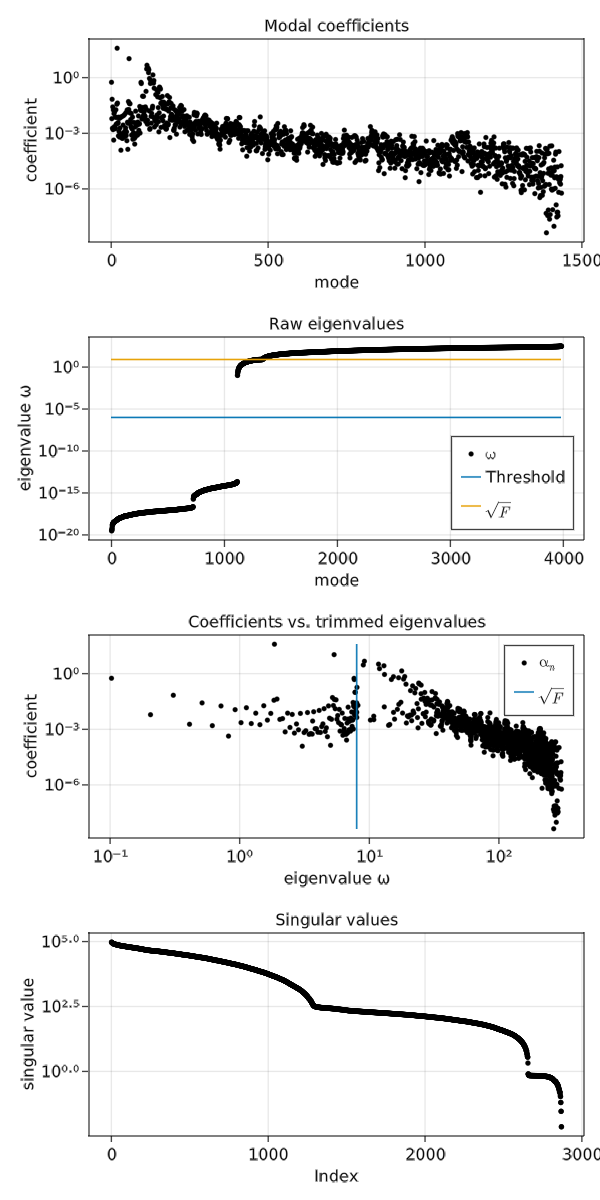

Done in [ 17.18]s.



In [7]:
αₙ = findExpansionCoefficients(ηmat) ;

#### 4. Make animation of the time dependent solution $\eta(t)$. 
Recall, the solution at time $t$ is
\begin{align}
\eta (t) = \eta_\infty + \Re \Big[ \sum_n \alpha_n \eta_n \exp \left( - i \omega_n t\right)  \Big] .
\end{align}
Compare this with the Oceananighans DNS solution from `RSW_channel_adjustment.ipynb` (see `RSW_adjustment_movie.key`).

In [8]:
# In \Delta t the numerator is in seconds and matches that from the Oceananighans notebook, except Oceananighans only plots every 4th (or 8th) timestep.
Δt = sqrt(F)*62.451210/timescale
nsteps = 512
Tf = nsteps*Δt
animateSolution(nsteps,Δt,Tf,ω,ηmat,αₙ,"eta") ;

Making animation of time dependent solution:
Writing output to [output/eta_results.mp4] with [512] steps of length [0.006245] and final time = [3.1975].


Done in [ 39.32]s.

